In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import cv2 
import sys
import seaborn as sns
import os
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import pickle
from matplotlib.patches import Patch
import scipy.spatial as spatial
from tqdm import tqdm
from utils import *
from scipy.stats import norm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
z = dict()
ks = [2, 5, 7, 10, 15, 20]
zs = np.zeros((6, 11, 12,))
for i, k in enumerate(ks):
    z[k] = pd.read_csv(f"./z_scores_{k}.csv").set_index("Unnamed: 0")
    zs[i] = z[k].to_numpy()

In [4]:
mean_z = np.mean(zs, axis=0)

| Cell type | Neighbors if ROI | Neighbors if Rest|
|---|---|---|
| B-cells | Basal keratinocytes, self| T-cells, Fibroblasts, None|
| Basal keratinocytes | T-cells, self| Melanocytes, Macrophages|


In [18]:
df.columns

Index(['B-cells', 'Basal keratinocytes', 'Endothelial cells', 'Fibroblasts',
       'Granulocytes', 'Langerhans cells', 'Macrophages', 'Melanocytes',
       'Smooth muscle cells', 'Suprabasal keratinocytes', 'T-cells', 'nan'],
      dtype='object')

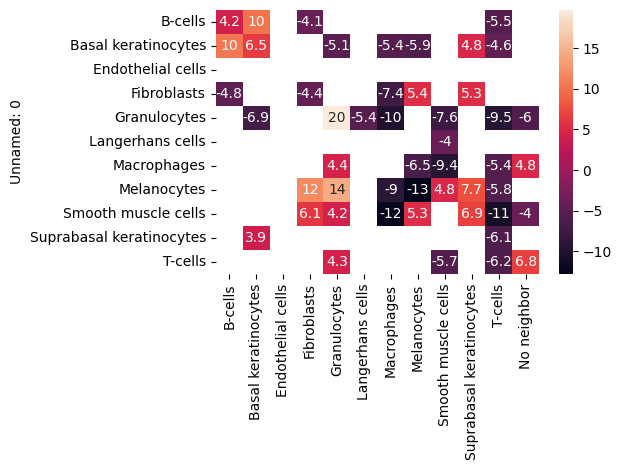

In [19]:
df = pd.DataFrame(mean_z, index=z[2].index, columns=z[2].columns)
df.rename({"nan": "No neighbor"}, axis=1, inplace=True)
sns.heatmap(df, mask=np.abs(mean_z) < 1.96*2, annot=True)
plt.tight_layout()
plt.savefig("zscores_heatmap.png")

In [6]:
pd.DataFrame(mean_z, index=z[2].index, columns=z[2].columns).to_csv("zmean.csv")

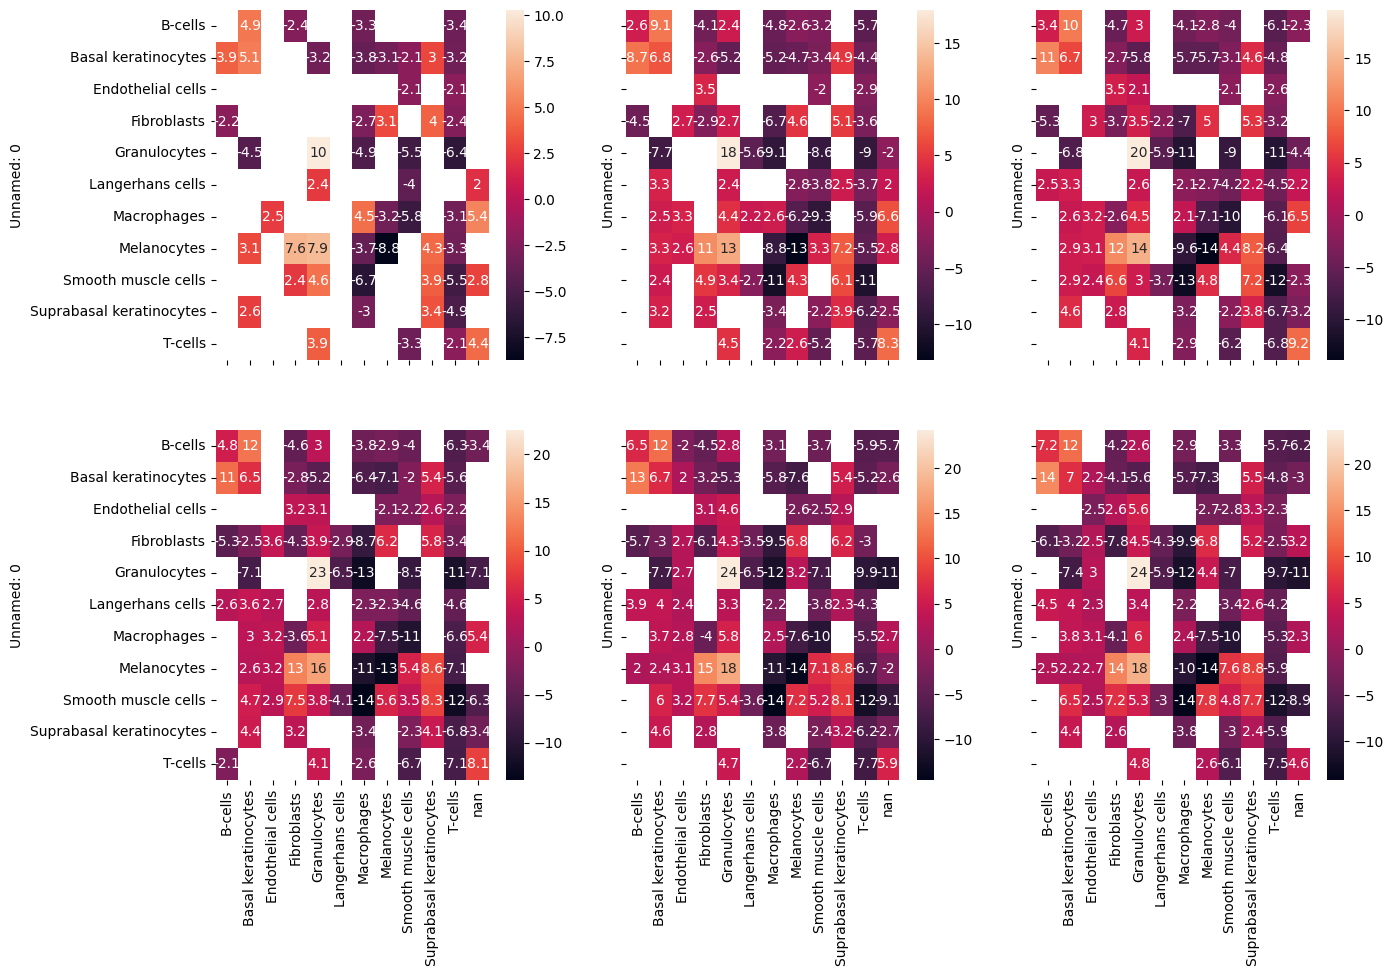

In [7]:
f, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 10))
for i, k in enumerate(ks):
    sns.heatmap(z[k], mask=np.abs(z[k])< 1.96, ax=axs[i//3, i%3], annot=True)

In [8]:
data = pd.read_csv("/data_nfs/datasets/melc/melc_clinical_data.csv")
dataset = "Melanoma"
data = data[data["Dataset"] == dataset]
data = data[~data["file_path"].isna()]
data = data[data["Group"] == "Melanoma"]
data = data.reset_index()
data = data[data["file_path"].isin([f[7:-4] for f in os.listdir("/data_nfs/je30bery/melanoma_data/ROI/filled/")])]
data = data[~data["file_path"].isna()]

In [9]:
np.unique(data["Type"], return_counts=True)

(array(['Acral Lentiginous Melanoma', 'Malignant Melanoma',
        'Superficial Spreading Melanoma'], dtype=object),
 array([ 1,  1, 14]))

In [10]:
with open("../THEORETIC/cell_coordinates.pickle", 'rb') as handle:
    cell_coordinates = pickle.load(handle)

In [11]:
cell_type_path = "../THEORETIC/sample_wise_results/"

In [12]:
pal = sns.color_palette("hls", 11)
cell_type_colors = {ct: pal[i] for i, ct in enumerate(['B-cells', 'Basal keratinocytes', 'Endothelial cells',
       'Fibroblasts', 'Granulocytes', 'Langerhans cells', 'Macrophages',
       'Melanocytes', 'Smooth muscle cells', 'Suprabasal keratinocytes',
       'T-cells'])}

In [13]:
print(os.getcwd())

/data_nfs/je30bery/melanoma_data/cell_type_analysis/cell_types_rois


In [14]:
ne = NeighborEnricher()
neighbor_df = ne.get_neighbors(data, cell_type_path, cell_coordinates, cell_type_colors, reload=False, expert_ROI=True)

  0%|                                                                                       | 0/16 [00:00<?, ?it/s]


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
n = 10
num_cell_types = 11
total_cells = len(neighbor_df["ROI"])
num_roi_cells = np.sum(neighbor_df["ROI"] == 1)
p = num_roi_cells / total_cells

diffs = np.zeros((n, num_cell_types))
for i in tqdm(range(n)):
    neighbor_df["random_ROI"] = np.random.choice([1, 0], total_cells, p=[p, 1-p])
    roi_neighbor_df = neighbor_df[neighbor_df["random_ROI"] == 1]
    roi_v, roi_c = np.unique(roi_neighbor_df["cell_type"].values.astype(str), return_counts=True)
    rni_neighbor_df = neighbor_df[neighbor_df["random_ROI"] == 0]
    rni_v, rni_c = np.unique(rni_neighbor_df["cell_type"].values.astype(str), return_counts=True)
    diffs[i] = roi_c / np.sum(roi_c) - rni_c / np.sum(rni_c)
means = np.mean(diffs, axis=0)
stds = np.std(diffs, axis=0)

In [ ]:
roi_neighbor_df = neighbor_df[neighbor_df["ROI"] == 1]
roi_v, roi_c = np.unique(roi_neighbor_df["cell_type"].values.astype(str), return_counts=True)
rni_neighbor_df = neighbor_df[neighbor_df["ROI"] == 0]
rni_v, rni_c = np.unique(rni_neighbor_df["cell_type"].values.astype(str), return_counts=True)
true_diff = roi_c / np.sum(roi_c) - rni_c / np.sum(rni_c)
z_scores = (true_diff - means) / stds
two_tailed_p_values = 2 * (1 - norm.cdf(abs(z_scores)))

In [ ]:
f, axs = plt.subplots(2, 1, sharex=True)
sns.boxplot(diffs, ax=axs[0])
axs[0].set_title(f"T-test with n={n}")
axs[0].scatter(roi_v, true_diff)

axs[1].scatter(roi_v, two_tailed_p_values)
axs[1].set_title("2-tailed p-values")
plt.hlines(0.05, xmin=0, xmax=10, linestyles="dashed", colors="grey")
plt.xticks(range(len(roi_v)), roi_v, rotation=90)
plt.show()

In [ ]:
bar_width = 0.4
roi_x = np.arange(len(roi_v))
rni_x = roi_x + bar_width

plt.bar(roi_x, roi_c / np.sum(roi_c), label="ROI", width=bar_width)
plt.bar(rni_x, rni_c / np.sum(rni_c), label="RNI", width=bar_width)
plt.xticks(roi_x + bar_width / 2, roi_v, rotation=90)
plt.legend()
plt.show()

In [ ]:
nbc = ne.get_neighbor_counts(neighbor_df, 20)

In [ ]:
nbc = nbc[nbc["Type"] == "Superficial Spreading Melanoma"].drop(["Type", "field_of_view"], axis=1)
roi, rni, diff = ne.get_neighbour_count_difference(nbc, random=False)

In [ ]:
means, stds = ne.get_pvalues_for_neighbors(nbc, diff, n=1000)

In [ ]:
f, axs= plt.subplots(1, 2, figsize=(15, 5))
z = (diff-means)/stds
sns.heatmap(z * (np.abs(z) > 3 * 1.96), annot=True, ax = axs[0])
pvals = pd.DataFrame(2 * (1 - norm.cdf(abs(z))), index=z.index, columns=z.columns)
sns.heatmap(pvals, annot=True, ax = axs[1], vmax=0.01)

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
sns.heatmap(roi_counts, ax=axs[0])
axs[0].set_title("ROI cells")
sns.heatmap(rni_counts, ax=axs[1])
axs[1].set_title("Rest of cells")
sns.heatmap(true_diff, ax=axs[2])
axs[2].set_title("Difference")
plt.show()

In [ ]:
p_val_df = pd.DataFrame(two_tailed_p_values[1], index=np.unique(count_df[1]["cell_type"]), columns=np.unique(count_df[1]["cell_type"]))
sns.heatmap(p_val_df, vmin=0, vmax=0.05)